In [1]:
# Этот файл посвящен исследованию датасета The Inria Aerial Image Labeling Dataset
# Согласно данным датасет содержит 180 изображений для 5 разных городов
# размером 5000*5000 с разрешением 0.3 м/пиксель
# План: 
# 1. Загрузить изображения, посмотреть на изображения и маски 
# 2. Посчитать на какой размер мы можем порезать изображения
# 3. Решить, будет ли после резки отсев изображений без строений
# 4. Сохранить получившийся набор изображений и масок

In [1]:
import os
import re

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import yaml

from tqdm.notebook import tqdm

from utils.dataset_process import DataOperations

%matplotlib inline

In [2]:
def load_data(input_dir, threshold=0, example=True):
    """
    Функция для загрузки данных
    По умолчанию загружает выбранные изображения по одному для каждого города
    """
    images_list = []
    masks_list = []
    
    images_dir = os.path.join(input_dir, 'images')
    masks_dir = os.path.join(input_dir, 'gt')
    
    all_image_files = sorted(os.listdir(images_dir))
    
    if example:
        image_files = [file for file in all_image_files if file.endswith('24.tif')]
    else:
        image_files = all_image_files
         
    mask_files = image_files #имена масок и изображений совпадают
    
    for img_name, mask_name in zip(image_files, mask_files):

        img_path = os.path.join(images_dir, img_name)
        mask_path = os.path.join(masks_dir, mask_name)
        
        img = cv2.imread(img_path)

        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        
        check =  np.sum(mask > 0) / mask.size
        
        if img is not None and mask is not None and check > threshold :
            images_list.append(img)
            masks_list.append(mask)
    
    print(f"Загружено {len(images_list)} изображений и {len(masks_list)} масок")
    return np.array(images_list), np.array(masks_list)

In [3]:
config_file = 'config.yml'
with open(config_file, "r", encoding="utf-8") as file:
            config = yaml.safe_load(file)

In [4]:
images, masks = load_data(config['main_folder'])

Загружено 5 изображений и 5 масок


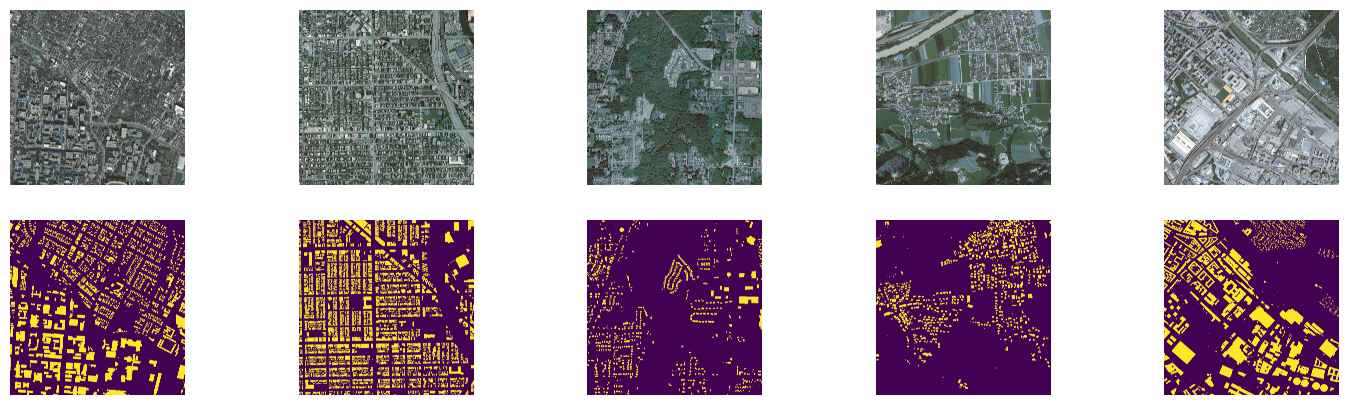

In [6]:
plt.figure(figsize=(18, 5))
for i in range(5):
    plt.subplot(2, 5, i+1)
    plt.axis("off")
    plt.imshow(images[i])

    plt.subplot(2, 5, i+6)
    plt.axis("off")
    plt.imshow(masks[i])
plt.show();

In [7]:
# Для примера было выбрано по одному изображения из каждого города - видно, что застройка 
# у городов отличается - различная местность, различные размеры зданий и
# плотность застройки - это будет одной из сложностей задачи  

In [8]:
def analyze_dataset(input_dir):
    """Анализ датасета: статистика, распределение классов и т.д."""
    # Категории оставлены в таком виде, чтоб для каждого города и каждого
    # масштаба было не по 2 изображения
    bins = [0, 0.25, 0.51]
    labels = ['0-25%', '26-51%']

    images_dir = os.path.join(input_dir, 'images')
    masks_dir = os.path.join(input_dir, 'gt')

    image_files = sorted(os.listdir(images_dir))
    mask_files = sorted(os.listdir(masks_dir))
    
    data = []
    
    for img_name, mask_name in tqdm(zip(image_files, mask_files), 
                                     total=len(image_files),
                                     desc="Analyzing dataset"):
        mask_path = os.path.join(masks_dir, mask_name)
        
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        
        stats = {
            'filename': img_name,
            'city': re.match(r'^([a-zA-Z]+)', str(img_name)).group(1),
            'building_pixels': np.sum(mask > 0),
            'background_pixels': np.sum(mask == 0),
            'building_ratio': np.sum(mask > 0) / mask.size if mask.size > 0 else 0
        }
        
        data.append(stats)
    
    df = pd.DataFrame(data)
    
    df['building_ratio_cat'] = pd.cut(df['building_ratio'], 
                                         bins=bins, 
                                         labels=labels, 
                                         right=True, 
                                         include_lowest=True)

    print(f"Всего изображений: {len(df)}")
    print(f"Средний процент застройки: {df['building_ratio'].mean()*100:.2f}%")
    print(f"Мин процент застройки: {df['building_ratio'].min()*100:.2f}%")
    print(f"Макс процент застройки: {df['building_ratio'].max()*100:.2f}%")

    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    df['building_ratio'].hist(bins=50) #, by=df['city'])
    plt.title('Распределение процента застройки')
    plt.xlabel('Процент застройки')
    plt.ylabel('Количество изображений')
    
    plt.tight_layout()
    plt.show()
    
    return df

Analyzing dataset:   0%|          | 0/180 [00:00<?, ?it/s]

Всего изображений: 180
Средний процент застройки: 16.48%
Мин процент застройки: 0.21%
Макс процент застройки: 50.37%


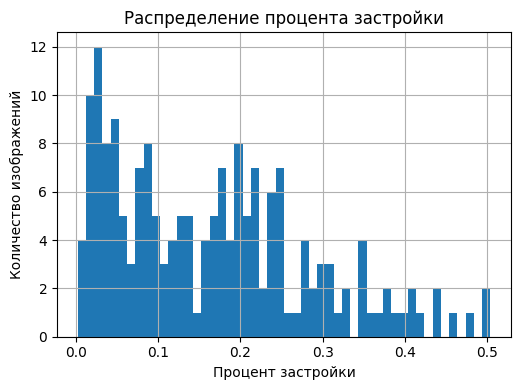

In [9]:
df_stats = analyze_dataset(config['main_folder'])

In [10]:
df_stats.head(5)

,filename,city,building_pixels,background_pixels,building_ratio,building_ratio_cat
0,austin1.tif,austin,4164770,22049630,0.158873,0-25%
1,austin10.tif,austin,2230210,23984190,0.085076,0-25%
2,austin11.tif,austin,4446559,21767841,0.169623,0-25%
3,austin12.tif,austin,5267340,20947060,0.200933,0-25%
4,austin13.tif,austin,4176911,22037489,0.159337,0-25%


In [11]:
df_stats['stratify'] = df_stats['city'] + '_' + df_stats['building_ratio_cat'].astype(str)
df_stats['stratify'].value_counts()

stratify
austin_0-25%      36
kitsap_0-25%      36
tyrol_0-25%       36
chicago_0-25%     22
vienna_26-51%     22
chicago_26-51%    14
vienna_0-25%      14
Name: count, dtype: int64

In [12]:
# Итак, даже если на первый взгляд застройка выглядит плотной, при анализе она едва ли
# превышает 50 процентов. Это нужно будет учесть при настройке обучения
# Но есть еще одна проблема. Работать с такими большими изображениями сложно
# И, в целом, стандартная практика для данного датасета это разрезание изображений на
# тайлы меньшего размера, например 512 или даже 256. Это упростит обработку и позволит
# создавать батчи не по 1 изображению.
# Однако, у нас небольшой процент застройки. Есть подозрение, что резка на тайлы ухудшит
# ситуацию

In [13]:
# Здесь будет небольшой спойлер - для анализа я использую уже преобразованные изображения
# То есть у них был изменен размер для удобства резки (5000x5000 -> 5120x5120), 
# что позволило разрезать оригиналы без перекрытия или пустот, затем изображения были
# разрезаны. Таким образом оригинальное изображение было разрезано на 100 тайлов без
# перекрытия, размером каждый 512х512

Analyzing dataset:   0%|          | 0/18000 [00:00<?, ?it/s]

Всего изображений: 18000
Средний процент застройки: 16.48%
Мин процент застройки: 0.00%
Макс процент застройки: 94.02%


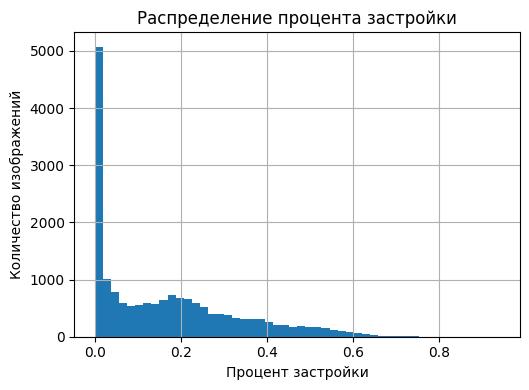

In [14]:
df_512_stats = analyze_dataset(config['main_folder_tiles'])

In [15]:
# Итак, после резки распределение растянулось, максимальная застройка теперь 95%. 
# Более того появилась проблема - очень много пустых тайлов

In [16]:
df_512_stats[df_512_stats['building_pixels']==0]

,filename,city,building_pixels,background_pixels,building_ratio,building_ratio_cat
0,austin10_tile_0000_y0_x0.png,austin,0,262144,0.0,0-25%
1,austin10_tile_0001_y0_x512.png,austin,0,262144,0.0,0-25%
2,austin10_tile_0002_y0_x1024.png,austin,0,262144,0.0,0-25%
3,austin10_tile_0003_y0_x1536.png,austin,0,262144,0.0,0-25%
6,austin10_tile_0006_y0_x3072.png,austin,0,262144,0.0,0-25%
...,...,...,...,...,...,...
17683,vienna6_tile_0083_y4096_x1536.png,vienna,0,262144,0.0,0-25%
17685,vienna6_tile_0085_y4096_x2560.png,vienna,0,262144,0.0,0-25%
17690,vienna6_tile_0090_y4608_x0.png,vienna,0,262144,0.0,0-25%
17693,vienna6_tile_0093_y4608_x1536.png,vienna,0,262144,0.0,0-25%


In [17]:
round((3176/18000)*100, 1)

17.6

In [18]:
# Примерно 17% тайлов - полностью пусты. В целом, звучит не так плохо, в конце концов в
# мире много не застроенных территорий. Однако, как быть с обучение - тратить ресурсы на
# предсказание пустых масок - довольно странно. Но и полностью убрать пустые тайлы нельзя,
# ведь модель может столкнуться с ними на продакшене. 
# Промежуточное решение - скоратить количество пустых тайлов для тренировки, но оставить
# все пустые тайлы для валидации и теста

In [19]:
round((600/3176)*100, 1)

18.9

In [20]:
# Было решено оставить 600 пустых тайлов из всех тренировочных пустых тайлов
# Но это решение требует дополнительного изучения 

In [21]:
blank_threshold = 600

In [22]:
# Теперь самое важное, а как же делить датасет на подвыборки, особенно с учетом резки
# на тайлы
# Если перемешать абсолютно все тайлы и разделить случайным образом может получиться, 
# что два соседних тайла одного оргинального изображения окажутся в разных выборках: 
# например в тренировочной и тестовой. Не будет ли это утечкой данных? Здания
# и их конфигурация на одном оригинальном изображении довольно похожи. Кажется, что так
# делать не стоит. К тому же не случайно в оригинальном соревновании тестирование модели
# проходит на совершенно новых городах - это в том числе проверка модели на умение
# обобщать, а не запоминать конкретные строения городов. 
# Таким образом, кажется, что лучше всего произвеси разделение на подвыборки по городам
# Три города - для тренировки и по одному для валидации и тестирования

In [23]:
df_stats['stratify'].value_counts()

stratify
austin_0-25%      36
kitsap_0-25%      36
tyrol_0-25%       36
chicago_0-25%     22
vienna_26-51%     22
chicago_26-51%    14
vienna_0-25%      14
Name: count, dtype: int64

In [24]:
# У нас три города имеют застройку только до 25% и еще два имеют несколько снимков
# с больше застройкой. Логично было бы их разделить,
# Пусть austin, tyrol и vienna - будут тренировочной выборкой
# kitsap - валидационной
# а chicago - тестовой

In [25]:
# Сформируем списки фалов, для каждой из выборок 
train_df = df_stats[df_stats['city'].isin(['austin', 'vienna', 'tyrol'])]
val_df = df_stats[df_stats['city'].isin(['kitsap'])]
test_df = df_stats[df_stats['city'].isin(['chicago'])]

train_files = train_df['filename'].tolist()
val_files = val_df['filename'].tolist()
test_files = test_df['filename'].tolist()

files_dist = {'train': train_files, 
              'val': val_files,
               'test': test_files}

In [28]:
dataset = DataOperations(
    input_dir = config["main_folder"],
    output_dir = config["dataset_folder"],
    files_dist = files_dist,
    save_resized=False,
    blank_threshold=blank_threshold,
)

# Метод изменит размеры изображений и разрежет, а так же сохранит все изображения
# для дальнейшей работы 
dataset.process_data(resize=5120, tile_size=512, overlap=0)

Processing files: 100%|██████████| 180/180 [08:16<00:00,  2.76s/it]
